In [2]:
import numpy as np

binet_flops = 0
strassen_flops = 0
alpha_tensor_flops = 0


def divide_matrix(M, n):
    """
    :return Four pieces of Matrix M (divided in half)
    This is auxiliary function for binet and strassen
    """
    A11 = M[0: n // 2, 0: n // 2]
    A12 = M[0: n // 2, n // 2: n]
    A21 = M[n // 2: n, 0: n // 2]
    A22 = M[n // 2: n, n // 2: n]

    return A11, A12, A21, A22


def divide_matrix_alpha_tensor(M, s_rows, s_cols):
    """
    :returns Divided matrix 4^p x 5^p or 5^p x 5^p
    s_rows - number of rows in each small Matrix;
    s_cols - number of cols in each small Matrix
    """
    # print(f'M = {M}\n s_rows = {s_rows}\n s_cols = {s_cols}')
    n = len(M) // s_rows
    m = len(M[0]) // s_cols
    # print(f'n = {n} m = {m}, s_rows = {s_rows}, s_cols = {s_cols}')
    divided_matrix = {(row, col): M[row * s_rows: (row + 1) * s_rows, col * s_cols: (col + 1) * s_cols]
                      for row in range(n) for col in range(m)}
    return divided_matrix


def binet(A: np.ndarray, B: np.ndarray):
    """
    :return: C = A * B where A, B, C are matrixs
    We can assume that dimensions of A and B are 2 ^ p.
    """
    global binet_flops

    n, m = len(A), len(A[0])
    p, q = len(B), len(B[0])

    if (n == 1 and m == 1) or (p == 1 and q == 1):
        binet_flops += 1
        return A * B

    A11, A12, A21, A22 = divide_matrix(A, n)
    B11, B12, B21, B22 = divide_matrix(B, n)

    C11 = binet(A11, B11) + binet(A12, B21)
    C12 = binet(A11, B12) + binet(A12, B22)
    C21 = binet(A21, B11) + binet(A22, B21)
    C22 = binet(A21, B12) + binet(A22, B22)

    # Add number of adding to flops
    binet_flops += 4 * len(C11) * len(C11[0])

    return np.vstack(
        (np.hstack((C11, C12)),
         np.hstack((C21, C22)))
    )


def strassen(A, B):
    """
    :return: C = A * B where A, B, C are matrixs
    We can assume that dimensions of A and B are 2 ^ p.
    """
    global strassen_flops
    n = len(A)

    if n == 1:
        strassen_flops += 1
        return A * B

    A11, A12, A21, A22 = divide_matrix(A, n)
    B11, B12, B21, B22 = divide_matrix(B, n)

    P1 = strassen(A11 + A22, B11 + B22)
    P2 = strassen(A21 + A22, B11)
    P3 = strassen(A11, (B12 - B22))
    P4 = strassen(A22, (B21 - B11))
    P5 = strassen(A11 + A12, B22)
    P6 = strassen(A21 - A11, B11 + B12)
    P7 = strassen(A12 - A22, B21 + B22)

    strassen_flops += 10 * len(A11) * len(A11[0])
    strassen_flops +=  8 * len(P1) * len(P1[0])
    return np.vstack(
        (np.hstack((P1 + P4 - P5 + P7, P3 + P5)),
         np.hstack((P2 + P4, P1 - P2 + P3 + P6)))
    )


def alpha_tensor(A, B):
    """
    :return C = A * B where A,B,C are matrixes
    We asume that dimensions of A are (4^p x 5^p) and B (5^p x 5^p)
    """

    # This is spec table that specifies how auxiliary matrices are creating
    if not hasattr(alpha_tensor, "spec"):
        alpha_tensor.spec = [{"A+": [(2, 1)], "B-": [(1, 0), (1, 4), (2, 0)], "A-": [], "B+": []},  # 1
                             {"A+": [(1, 1), (1, 4)], "B-": [(1, 4), (4, 0)], "A-": [(2, 4)], "B+": []},  # 2
                             {"A+": [(3, 1)], "B-": [(0, 0)], "A-": [(2, 0), (3, 0)], "B+": [(1, 4)]},  # 3
                             {"A+": [(0, 1), (0, 3), (2, 3)], "B-": [(1, 4), (3, 0)], "A-": [], "B+": []},  # 4
                             {"A+": [(0, 4), (1, 1), (1, 4)], "B-": [(1, 3)], "A-": [], "B+": [(4, 0)]},  # 5
                             {"A+": [], "B-": [], "A-": [(1, 1), (1, 4), (3, 4)], "B+": [(1, 2), (4, 0)]},  # 6
                             {"A+": [(3, 0)], "B-": [], "A-": [(0, 0), (3, 1)], "B+": [(0, 0), (1, 3)]},  # 7
                             {"A+": [(2, 1)], "B-": [(1, 2)], "A-": [(2, 2), (3, 2)], "B+": [(2, 0)]},  # 8
                             {"A+": [(3, 3)], "B-": [], "A-": [(0, 1), (0, 3)], "B+": [(1, 2), (3, 0)]},  # 9
                             {"A+": [(1, 1), (1, 4)], "B-": [], "A-": [], "B+": [(4, 0)]},  # 10
                             {"A+": [(3, 1)], "B-": [(0, 0)], "A-": [(1, 0), (3, 0)], "B+": [(1, 1)]},  # 11
                             {"A+": [(3, 0)], "B-": [], "A-": [(3, 1)], "B+": [(0, 0)]},  # 12
                             {"A+": [(0, 1), (0, 3), (1, 3)], "B-": [], "A-": [], "B+": [(1, 1), (3, 0)]},  # 13
                             {"A+": [(0, 2), (2, 2)], "B-": [], "A-": [(2, 1)], "B+": [(1, 3), (2, 0)]},  # 14
                             {"A+": [], "B-": [], "A-": [(0, 1), (0, 3)], "B+": [(3, 0)]},  # 15
                             {"A+": [(2, 2)], "B-": [], "A-": [(2, 1)], "B+": [(2, 0)]},  # 16
                             {"A+": [(0, 1), (0, 3), (1, 1), (1, 3), (2, 2), (3, 1)], "B-": [],  # 17
                              "A-": [(1, 0), (1, 2), (2, 1), (3, 0)], "B+": [(1, 1)]},
                             {"A+": [(1, 0)], "B-": [], "A-": [], "B+": [(0, 0), (0, 1), (4, 1)]},  # 18
                             {"A+": [], "B-": [], "A-": [(1, 2)], "B+": [(2, 0), (2, 1), (4, 1)]},  # 19
                             {"A+": [(1, 0), (1, 2)], "B-": [(0, 0), (0, 1), (4, 1)], "A-": [(0, 4), (1, 4)],
                              "B+": [(0, 3)]},
                             {"A+": [(1, 0), (1, 2)], "B-": [], "A-": [(1, 4)], "B+": [(4, 1)]},  # 20
                             {"A+": [(0, 2)], "B-": [(0, 3), (2, 0), (2, 1)], "A-": [(0, 3), (1, 3)],  # 21
                              "B+": [(0, 0), (0, 1), (2, 3), (3, 3)]},
                             {"A+": [(0, 2)], "B-": [(2, 0)], "A-": [], "B+": [(2, 3), (3, 3)]},  # 22
                             {"A+": [(0, 4)], "B-": [(3, 3), (4, 0)], "A-": [], "B+": [(4, 3)]},  # 23
                             {"A+": [], "B-": [(0, 3)], "A-": [(0, 0)], "B+": [(0, 0)]},  # 24
                             {"A+": [(0, 3), (0, 4)], "B-": [], "A-": [(0, 2)], "B+": [(3, 3)]},  # 25
                             {"A+": [(0, 2), (2, 2)], "B-": [(0, 3)], "A-": [(2, 0)], "B+": [(0, 0), (0, 4), (2, 4)]},
                             # 26
                             {"A+": [], "B-": [(2, 4), (3, 0), (3, 4)], "A-": [(2, 3)], "B+": []},  # 27
                             {"A+": [(2, 0)], "B-": [], "A-": [], "B+": [(0, 0), (0, 4), (2, 4)]},  # 28
                             {"A+": [(2, 0), (2, 3)], "B-": [], "A-": [(2, 2)], "B+": [(2, 4)]},  # 29
                             {"A+": [], "B-": [(3, 3), (4, 0), (4, 4)], "A-": [(0, 3), (0, 4), (2, 3)], "B+": [(4, 3)]},
                             # 30
                             {"A+": [(1, 0), (3, 0), (3, 3)], "B-": [(3, 0), (3, 1), (3, 2)], "A-": [], "B+": [(0, 2)]},
                             # 31
                             {"A+": [(3, 2)], "B-": [(2, 0), (2, 2)], "A-": [], "B+": []},  # 32
                             {"A+": [(3, 3)], "B-": [(0, 2)], "A-": [], "B+": [(3, 0), (3, 2)]},  # 33
                             {"A+": [], "B-": [], "A-": [(3, 4)], "B+": [(0, 2), (4, 0), (4, 2)]},  # 34
                             {"A+": [(1, 2)], "B-": [], "A-": [(1, 4), (3, 4)], "B+": [(2, 0), (2, 1), (2, 2), (4, 1)]},
                             # 35
                             {"A+": [(3, 4)], "B-": [], "A-": [(3, 0), (3, 3)], "B+": [(0, 2)]},  # 36
                             {"A+": [(2, 2)], "B-": [], "A-": [(1, 2), (2, 0), (2, 3)],  # 37
                              "B+": [(2, 4), (3, 0), (3, 1), (3, 4)]},
                             {"A+": [(3, 4)], "B-": [], "A-": [(2, 0), (3, 0), (3, 3)],  # 38
                              "B+": [(0, 2), (4, 0), (4, 2), (4, 4)]},
                             {"A+": [(0, 3), (0, 4)], "B-": [(2, 0), (2, 2)], "A-": [(0, 2), (3, 3)],  # 39
                              "B+": [(2, 3), (3, 3)]},
                             {"A+": [(3, 0)], "B-": [(2, 3), (4, 3)], "A-": [(0, 0), (3, 4)],
                              "B+": [(0, 2), (2, 0), (2, 2), (4, 0), (4, 2)]},  # 40
                             {"A+": [(1, 4)], "B-": [(0, 0), (0, 1), (0, 4), (4, 1)], "A-": [(1, 0), (2, 4)],  # 41
                              "B+": [(3, 0), (3, 1), (3, 4)]},
                             {"A+": [(1, 3)], "B-": [], "A-": [], "B+": [(3, 0), (3, 1)]},  # 42
                             {"A+": [(1, 2), (2, 1)], "B-": [(2, 0)], "A-": [(2, 2)], "B+": [(1, 1)]},  # 43
                             {"A+": [(2, 3)], "B-": [], "A-": [(2, 2), (3, 2)],  # 44
                              "B+": [(2, 4), (3, 0), (3, 2), (3, 4), (4, 0), (4, 2), (4, 4)]},
                             {"A+": [], "B-": [(4, 0), (4, 4)], "A-": [(2, 4)], "B+": []},  # 45
                             {"A+": [(1, 0), (2, 4)], "B-": [(3, 0), (3, 1), (3, 4)], "A-": [(1, 4), (2, 0)],  # 46
                              "B+": [(0, 0), (0, 1), (0, 4)]},
                             {"A+": [(2, 2)], "B-": [], "A-": [(1, 2)],  # 47
                              "B+": [(1, 1), (2, 1), (2, 4), (3, 0), (3, 1), (3, 4)]},
                             {"A+": [(0, 3), (0, 4), (1, 3), (1, 4)], "B-": [(0, 0), (0, 1)],  # 48
                              "A-": [(0, 0), (0, 2), (1, 0), (1, 2)], "B+": [(0, 3)]},
                             {"A+": [], "B-": [(2, 0), (2, 1), (3, 1)], "A-": [(0, 3), (1, 3)],  # 49
                              "B+": [(1, 1), (2, 3), (3, 3)]},
                             {"A+": [(1, 1)], "B-": [(4, 0)], "A-": [], "B+": [(1, 0), (1, 1)]},  # 50
                             {"A+": [(3, 1)], "B-": [], "A-": [], "B+": [(0, 0), (1, 0), (1, 2)]},  # 51
                             {"A+": [], "B-": [(1, 0)], "A-": [(0, 1)], "B+": [(1, 3), (3, 0)]},  # 52
                             {"A+": [(0, 1), (0, 3), (2, 2), (3, 2)], "B-": [],  # 53
                              "A-": [(1, 1), (1, 4), (2, 1), (3, 1), (3, 3), (3, 4)], "B+": [(1, 2)]},
                             {"A+": [(0, 3)], "B-": [(1, 2), (2, 3), (3, 3)], "A-": [(3, 3)],  # 54
                              "B+": [(2, 0), (2, 2), (3, 2)]},
                             {"A+": [(0, 0), (3, 4)], "B-": [(2, 3), (4, 3)], "A-": [(0, 4), (3, 0)],  # 55
                              "B+": [(2, 0), (2, 2), (4, 0), (4, 2)]},
                             {"A+": [], "B-": [(0, 2), (0, 4), (1, 4), (4, 0), (4, 2), (4, 4)], "A-": [(2, 0), (3, 0)],
                              # 56
                              "B+": []},
                             {"A+": [], "B-": [(4, 0), (4, 4)], "A-": [(0, 3), (0, 4), (2, 3), (2, 4)], "B+": [(4, 3)]},
                             # 57
                             {"A+": [(2, 3), (3, 3)], "B-": [], "A-": [(2, 2), (3, 2)],  # 58
                              "B+": [(3, 0), (3, 2), (3, 4), (4, 0), (4, 2), (4, 4)]},
                             {"A+": [(1, 4), (3, 4)], "B-": [(2, 0), (2, 1), (2, 2), (4, 1), (4, 2)], "A-": [],  # 59
                              "B+": [(1, 2)]},
                             {"A+": [(0, 3), (2, 3)], "B-": [(0, 3), (1, 4), (3, 3), (4, 0), (4, 4)], "A-": [],  # 60
                              "B+": [(0, 0), (0, 4), (3, 4), (4, 3)]},
                             {"A+": [(1, 0), (3, 0)], "B-": [(3, 0), (3, 1), (3, 2)], "A-": [],  # 61
                              "B+": [(0, 1), (0, 2), (1, 1)]},
                             {"A+": [], "B-": [(1, 2), (2, 2), (2, 4), (3, 0), (3, 2), (3, 4)], "A-": [(2, 2), (3, 2)],
                              # 62
                              "B+": []},
                             {"A+": [(0, 0), (2, 0)], "B-": [(0, 3)], "A-": [(0, 2), (0, 3), (2, 2), (2, 3)],  # 63
                              "B+": [(0, 0), (0, 4)]},
                             {"A+": [(3, 0)], "B-": [(0, 2), (4, 0), (4, 2)], "A-": [(0, 0)],  # 64
                              "B+": [(0, 3), (1, 3), (4, 3)]},
                             {"A+": [(0, 0), (0, 2), (2, 2), (3, 1)], "B-": [],  # 65
                              "A-": [(0, 1), (0, 4), (1, 1), (1, 4), (2, 1), (3, 0)], "B+": [(1, 3)]},
                             {"A+": [(1, 4)], "B-": [(1, 4), (3, 0), (3, 1), (3, 4)], "A-": [(2, 4)],  # 66
                              "B+": [(0, 0), (0, 1), (0, 4), (4, 1), (4, 4)]},
                             {"A+": [(0, 0), (0, 2), (3, 3), (3, 4)], "B-": [(2, 0), (2, 2)],  # 67
                              "A-": [(0, 3), (0, 4), (3, 0), (3, 2)], "B+": [(2, 3)]},
                             {"A+": [(0, 3), (1, 3)], "B-": [(1, 3), (2, 0), (2, 1), (4, 1)], "A-": [(0, 2), (1, 2)],
                              # 68
                              "B+": [(2, 3), (4, 3)]},
                             {"A+": [(1, 2), (3, 2)], "B-": [(2, 0), (2, 1), (2, 2)], "A-": [(1, 4), (3, 4)], "B+": []},
                             # 69
                             {"A+": [(2, 2), (2, 4), (3, 2), (3, 4)], "B-": [(4, 0), (4, 2), (4, 4)],  # 70
                              "A-": [(2, 0), (2, 3), (3, 0), (3, 3)], "B+": []},
                             {"A+": [], "B-": [], "A-": [(1, 0), (1, 3), (3, 0), (3, 3)],  # 71
                              "B+": [(3, 0), (3, 1), (3, 2)]},
                             {"A+": [(0, 2), (1, 2)], "B-": [(0, 3), (4, 3)], "A-": [(0, 3), (0, 4), (1, 3), (1, 4)],
                              "B+": [(0, 0), (0, 1), (1, 3), (4, 1)]},  # 72
                             {"A+": [(1, 0), (1, 3), (2, 2)], "B-": [], "A-": [(1, 2), (2, 0), (2, 3)],
                              "B+": [(3, 0), (3, 1), (3, 4)]},  # 73
                             {"A+": [(1, 1), (1, 4), (2, 0), (3, 0), ], "B-": [],
                              "A-": [(0, 1), (0, 3), (2, 1), (2, 3), (2, 4), (3, 1)], "B+": [(1, 4)]},  # 74
                             {"A+": [(0, 2), (2, 2)], "B-": [(0, 0), (0, 4), (2, 4)], "A-": [],  # 75
                              "B+": [(0, 3), (1, 3), (2, 3)]}
                             ]

    global alpha_tensor_flops
    n = len(A)
    m = len(B)

    # End condition
    if n == 1 or m == 1:
        alpha_tensor_flops += 1
        return A * B

    # Dividing matrix into grids
    A_divided = divide_matrix_alpha_tensor(A, n // 4, len(A[0]) // 5)
    B_divided = divide_matrix_alpha_tensor(B, m // 5, len(B[0]) // 5)

    h = [0]  # To start index from 1
    # Preparing auxiliary matrices h
    for i in range(76):
        A_plus, A_minus = np.zeros((n // 4, len(A[0]) // 5)), np.zeros((n // 4, len(A[0]) // 5))
        B_plus, B_minus = np.zeros((m // 5, len(B[0]) // 5)), np.zeros((m // 5, len(B[0]) // 5))
        spec = alpha_tensor.spec[i]

        for row, col in spec['A+']:
            A_plus += A_divided[(row, col)]

        for row, col in spec['A-']:
            A_minus -= A_divided[(row, col)]

        for row, col in spec['B+']:
            B_plus += B_divided[(row, col)]

        for row, col in spec['B-']:
            B_minus -= B_divided[(row, col)]

        h.append(alpha_tensor(A_plus + A_minus, B_plus + B_minus))

    # Calculating matrix C
    C11 = -h[10] + h[12] + h[14] - h[15] - h[16] + h[53] + h[5] - h[66] - h[7]
    C21 = h[10] + h[11] - h[12] + h[13] + h[15] + h[16] - h[17] - h[44] + h[51]
    C31 = h[10] - h[12] + h[15] + h[16] - h[1] + h[2] + h[3] - h[4] + h[75]
    C41 = -h[10] + h[12] - h[15] - h[16] + h[52] + h[54] - h[6] - h[8] + h[9]
    C12 = h[13] + h[15] + h[20] + h[21] - h[22] + h[23] + h[25] - h[43] + h[49] + h[50]
    C22 = -h[11] + h[12] - h[13] - h[15] - h[16] + h[17] + h[18] - h[19] - h[21] + h[43] + h[44]
    C32 = -h[16] - h[19] - h[21] - h[28] - h[29] - h[38] + h[42] + h[44] - h[47] + h[48]
    C42 = h[11] - h[12] - h[18] + h[21] - h[32] + h[33] - h[34] - h[36] + h[62] - h[70]
    C13 = h[15] + h[23] + h[24] + h[34] - h[37] + h[40] - h[41] + h[55] - h[56] - h[9]
    C23 = -h[10] + h[19] + h[32] + h[35] + h[36] + h[37] - h[43] - h[60] - h[6] - h[72]
    C33 = -h[16] - h[28] + h[33] + h[37] - h[39] + h[45] - h[46] + h[63] - h[71] - h[8]
    C43 = h[10] + h[15] + h[16] - h[33] + h[34] - h[35] - h[37] - h[54] + h[6] + h[8] - h[9]
    C14 = -h[10] + h[12] + h[14] - h[16] + h[23] + h[24] + h[25] + h[26] + h[5] - h[66] - h[7]
    C24 = h[10] + h[18] - h[19] + h[20] - h[22] - h[24] - h[26] - h[5] - h[69] + h[73]
    C34 = -h[14] + h[16] - h[23] - h[26] + h[27] + h[29] + h[31] + h[46] - h[58] + h[76]
    C44 = h[12] + h[25] + h[26] - h[33] - h[35] - h[40] + h[41] + h[65] - h[68] - h[7]
    C15 = h[15] + h[24] + h[25] + h[27] - h[28] + h[30] + h[31] - h[4] + h[61] + h[64]
    C25 = -h[10] - h[18] - h[2] - h[30] - h[38] + h[42] - h[43] + h[46] + h[67] + h[74]
    C35 = -h[10] + h[12] - h[15] + h[28] + h[29] - h[2] - h[30] - h[3] + h[46] + h[4] - h[75]
    C45 = -h[12] - h[29] + h[30] - h[34] + h[35] + h[39] + h[3] - h[45] + h[57] + h[59]

    return np.vstack(
        (np.hstack((C11, C12, C13, C14, C15)),
         np.hstack((C21, C22, C23, C24, C25)),
         np.hstack((C31, C32, C33, C34, C35)),
         np.hstack((C41, C42, C43, C44, C45)),)
    )


def get_and_reset_flops(function_name):
    """
    Returns number of flops depends on function_name
    """
    global strassen_flops, binet_flops, alpha_tensor_flops
    to_return = None

    if function_name == strassen.__name__:
        to_return = strassen_flops
        strassen_flops = 0

    elif function_name == binet.__name__:
        to_return = binet_flops
        binet_flops = 0

    elif function_name == alpha_tensor.__name__:
        to_return = alpha_tensor_flops
        alpha_tensor_flops = 0

    return to_return





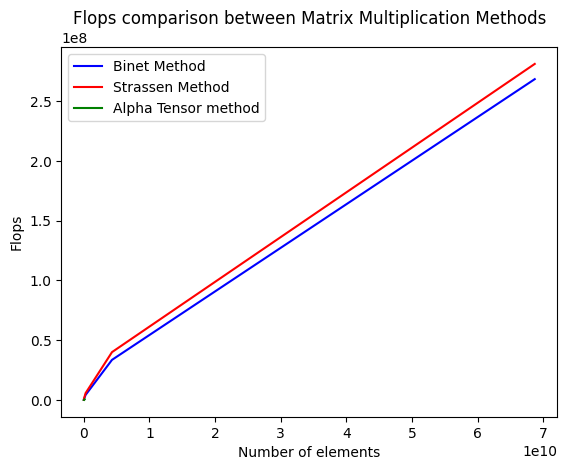

In [6]:
from matrix_multiplication import binet, strassen, alpha_tensor, get_and_reset_flops
import numpy as np
from matplotlib import pyplot as plt
import time

EPSILON = 10 ** -8


def is_same(A1, A2):
    """
    Checks if A1 contains the same numbers as A2 (with possible error = EPSILON) on every number.
    """
    for r_id, row in enumerate(A1):
        for el_id, el in enumerate(row):
            if abs(el - A2[r_id, el_id]) > EPSILON:
                return False

    return True


def perform_tests(dims):
    """
    Perform  time and correct test on every function from dims.keys().
    Return tuples (flops, times) where flops is number of floating point operation in A * B and time is whole time
    for A * B operation
    """
    times = {f.__name__: [] for f in dims.keys()}
    flops = {f.__name__: [] for f in dims.keys()}

    for f, dim_list in dims.items():
        for dim1, dim2 in dim_list:
            A = np.random.rand(dim1[0], dim1[1])
            B = np.random.rand(dim2[0], dim2[1])

            time_f = time.time()
            if not is_same(f(A, B), A @ B):
                print()
                return False

            times[f.__name__].append(time.time() - time_f)
            flops[f.__name__].append(get_and_reset_flops(f.__name__))

    return flops, times


def plot(y, x, xlabel, ylabel, title):
    plt.plot(x['binet'], y['binet'], label="Binet Method", color='blue')
    plt.plot(x['strassen'], y['strassen'], label="Strassen Method", color='red')
    plt.plot(x['alpha_tensor'], y['alpha_tensor'], label="Alpha Tensor method", color='green')

    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend()
    plt.title(title)

    plt.show()


binet_strassen_dims = [[(2, 2), (2, 2)], [(4, 4), (4, 4)], [(8, 8), (8, 8)], [(16, 16), (16, 16)],
                       [(32, 32), (32, 32)], [(64, 64), (64, 64)], [(128, 128), (128, 128)],
                         [(256, 256), (256, 256)], [(512, 512), (512, 512)]]
alpha_tensor_dims = [[(4, 5), (5, 5)], [(16, 25), (25, 25)], [(64, 125), (125, 125)]]

products_binet_strassen = list(map(lambda sub_arr: [x * y for x, y in sub_arr], binet_strassen_dims))

binet_strassen_elements = list(map(lambda sub_arr: sub_arr[0] * sub_arr[1], products_binet_strassen))

products_alpha_tensor = list(map(lambda sub_arr: [x * y for x, y in sub_arr], alpha_tensor_dims))
alpha_tensor_elemets = list(map(lambda sub_arr: sub_arr[0] * sub_arr[1], products_alpha_tensor))

dims = {binet: binet_strassen_dims,
        strassen: binet_strassen_dims,
        alpha_tensor: alpha_tensor_dims}
flops, times = perform_tests(dims)

number_of_elements = {binet.__name__: binet_strassen_elements,
                      strassen.__name__: binet_strassen_elements,
                      alpha_tensor.__name__: alpha_tensor_elemets}

plot(flops, number_of_elements, 'Number of elements', 'Flops', 'Flops comparison between Matrix Multiplication Methods')



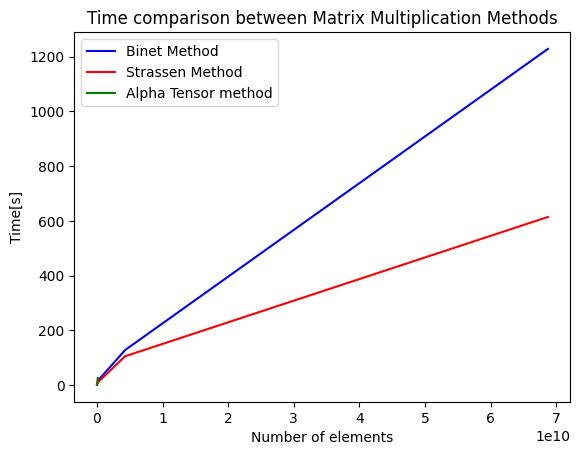

In [7]:
plot(times, number_of_elements, 'Number of elements', 'Time[s]',
     'Time comparison between Matrix Multiplication Methods')

In [13]:
A = np.array([[1, 2],[ 3, 4]])
B = np.array([[5, 6],[ 7, 8]])

A2 = np.array(
    [
        [1, 2, 3, 4, 5],
        [6, 7, 8, 9, 0],
        [1, 2, 3, 4, 5],
        [6, 7, 8, 9, 0]
    ]
)
B2 = np.array(
    [
        [1, 2, 3, 4, 5],
        [6, 7, 8, 9, 0],
        [1, 2, 3, 4, 5],
        [6, 7, 8, 9, 0],
        [1, 2, 3, 4, 5]
    ]
)

print(binet(A, B))
print(strassen(A, B))
print(alpha_tensor(A2, B2))

[[19 22]
 [43 50]]
[[19 22]
 [43 50]]
[[ 45.  60.  75.  90.  45.]
 [110. 140. 170. 200.  70.]
 [ 45.  60.  75.  90.  45.]
 [110. 140. 170. 200.  70.]]
